### Training 

The srbm is trained with data similar to the one used by Finnegan et al. (2015)

/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Please run the data generation file if not done so yet!!

Number of seed patterns:                      5
Number of prototypes per seed patterns        10
Number of prototypes total:                   50
Number of variations per prototype            10
Number of patterns total                      500
Number of input neurons (stimulus length):    100
Number of hidden neurons:                     500
Number of class neurons:                      0
Number of class neurons per class:            0
Data loaded from data/data_100_10_01_005.pkl

Variations per prototype in train set after train-test-split: 9
Variations per prototype in test set after train-test-split:  1

Each group consists of 45 randomized patterns. 
The patterns for the first group consist of the 9 variations of the first of the 10 prototypes 
that were generated for each of the 5 seed patterns. 
Practically, that means that the first group consists of the 9 variations of the first prototype 
generated of the first seed p

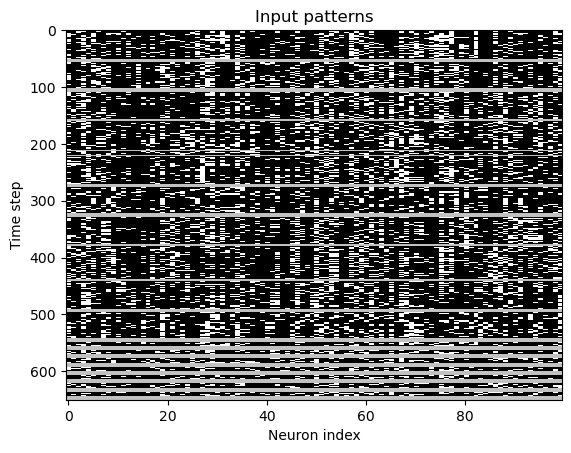

The input patterns are shown above. 
After each group of 45 patterns, test patterns for each prototype are shown. 
In the end all test patterns are shown. 



In [1]:
import numpy as np 
from tools.srbm import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt
from brian2tools import *
from tools.parameters import *
from generate_data import *

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

# Some parameters for training the SRBM - the others are in paramters_main.py

T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms

n_samples = 1000

# Loading the data
data_finnegan = load_data("data_100_10_01_005")

train_test_data = train_test_split_finnegan(data_finnegan, 0.9)

print("\nVariations per prototype in train set after train-test-split: " + str(len(train_test_data[0][0])))
print("Variations per prototype in test set after train-test-split:  " + str(len(train_test_data[1][0])))

off_time = 1 # How many frames should be after a test pattern before the next test pattern is presented?

# Create the Ids. Test patterns are not randomized!
Ids, time_test_on, time_test_off = create_finnegan_Ids(train_test_data, off_time = 1)

print("\nEach group consists of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " randomized patterns. \n" +
      "The patterns for the first group consist of the " + str(len(train_test_data[0][0])) + " variations of " + 
      "the first of the " + str(n_prototype_per_seed) +  " prototypes \nthat were generated for each of the " + str(n_seed_patterns) + " seed patterns. \n" + 
      "Practically, that means that the first group consists of the 9 variations of the first prototype \n" + 
      "generated of the first seed pattern + the 9 variations of the first prototype generated of the second \n" + 
      "seed pattern, etc., making " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns in total. \n" + 
      "The second group consists of the 9 variations of the second prototype generated of the first seed \n" + 
      "pattern + the 9 variations of the second prototype generated of the second seed pattern, etc.")

fig, ax = plt.subplots()
plt.imshow(Ids, cmap='gray', aspect='auto', interpolation= "None")
plt.xlabel("Neuron index")
plt.ylabel("Time step")
plt.title("Input patterns")
plt.show()
print("The input patterns are shown above. \n" +
      "After each group of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns, test patterns for each prototype are shown. \n" + 
      "In the end all test patterns are shown. \n")



In [2]:
## shorten ids for trials!
#Ids = Ids[0:10] * 0
#Ids = np.repeat(Ids[1], 30).reshape(200, 30).T

In [3]:
# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

# Create timepoints for classificaiton
# One timepoint for each input pattern. Starts with timepoint 1
timepoints, t_sim, time_points_dict = create_timepoints(Ids, init_delay, delay, T)

# Calculate simulation time for accurate neural growth
sim_time = (t_sim / (dcmt*t_ref))

In [4]:
# SRBM main function
# leak helper is sensistivity ov average
print("Starting the SRBM simulation...")
out = main(W, b_v, b_c, b_h, Id = Ids, sim_time = sim_time, t_sim = t_sim, p_target = 1e-10, 
           sparsity_cost = 1e-4 * 0 , leak_helper = 10, dorun = True, n_classes = 5, 
            monitors = True, display=False, age_neurons = False, generations = 1, 
            connectivity_born=0.8, connectivity_mature=0.8, lock_connectivity = True) # set display to false if no lables are used 
locals().update(out)

Starting the SRBM simulation...
ageing factor:  0.025601638504864334


INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_6tk55lpf/var
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_6tk55lpf/var/folders
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_6tk55lpf/var/folders/07
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_6tk55lpf/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_6tk55lpf/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_6tk55lpf/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_6tk55lpf
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -fPIC -O2 -isystem /opt/homebrew

Starting simulation at t=0. s for a duration of 156.24 s
7.6767 s (4%) simulated in 10s, estimated 3m 14s remaining.
16.3101 s (10%) simulated in 20s, estimated 2m 52s remaining.
25.1309 s (16%) simulated in 30s, estimated 2m 37s remaining.
33.4384 s (21%) simulated in 40s, estimated 2m 27s remaining.
42.0968 s (26%) simulated in 50s, estimated 2m 16s remaining.
50.549 s (32%) simulated in 1m 0s, estimated 2m 5s remaining.
56.3801 s (36%) simulated in 1m 10s, estimated 2m 4s remaining.
65.3822 s (41%) simulated in 1m 20s, estimated 1m 51s remaining.
74.3473 s (47%) simulated in 1m 30s, estimated 1m 39s remaining.
83.2583 s (53%) simulated in 1m 40s, estimated 1m 28s remaining.
92.1001 s (58%) simulated in 1m 50s, estimated 1m 17s remaining.
100.9057 s (64%) simulated in 2m 0s, estimated 1m 6s remaining.
104.8577 s (67%) simulated in 2m 12s, estimated 1m 5s remaining.
113.7515 s (72%) simulated in 2m 22s, estimated 53s remaining.
122.7145 s (78%) simulated in 2m 32s, estimated 42s remai

In [5]:
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']
sMhh_age = out["sMhh_age"]
sMhh_av_act = out["sMhh_av_act"]
sMh_age = out["sMh_age"]
sMh_v = out["sMh_v"]
sMhh_age = out["sMhh_age"]
sMh_q = out["sMh_q"]
weights = out["weights"]
connections = out["connections"]

In [6]:
""" import pandas as pd
df = pd.DataFrame(weights)
df.to_csv("weights.csv") """

' import pandas as pd\ndf = pd.DataFrame(weights)\ndf.to_csv("weights.csv") '

WARNING    /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/brian2tools/plotting/data.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axes.plot(spike_times/time_unit, spike_indices, '.', **kwds)
 [py.warnings]
  axes.plot(spike_times/time_unit, spike_indices, '.', **kwds)



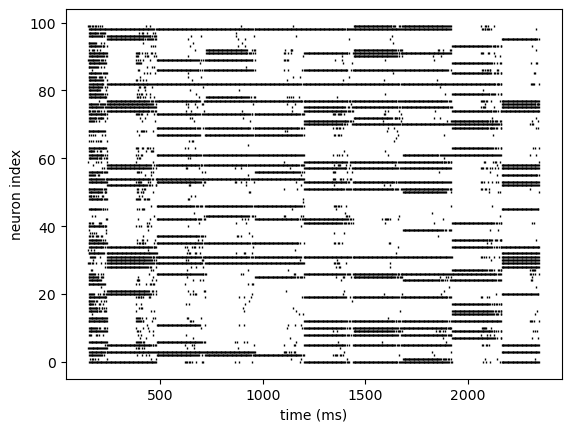

' n_neurons = 1\nfor i in np.arange(n_neurons):\n    plt.plot(sMh_age.t/ms, gomperz_function(sMh_age.age[i], 2), linewidth=1)\nplt.ylim(-0.2, 1.2)\n\nplt.show() '

In [7]:
t_start = 1
t_stop = 9
precision = 1
idx_start = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]
idx_stop = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]
plot_raster(Mv.i[idx_start:idx_stop], Mv.t[idx_start:idx_stop], markersize=2,marker='|', color='k', mew=1)
plt.show()


# Some plots - use only with small trial sets!
""" n_neurons = 1
for i in np.arange(n_neurons):
    plt.plot(sMh_age.t/ms, gomperz_function(sMh_age.age[i], 2), linewidth=1)
plt.ylim(-0.2, 1.2)

plt.show() """


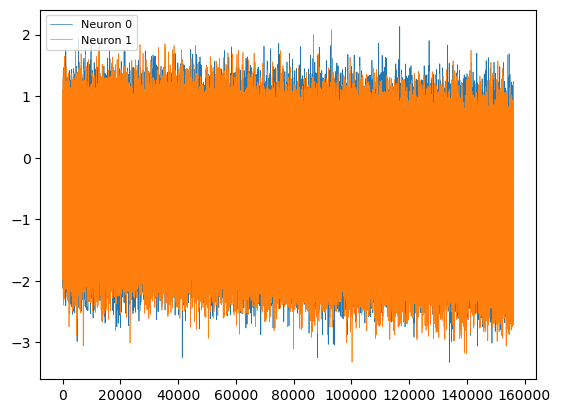

In [8]:
""" n_neurons = 2
for i in np.arange(n_neurons):
    plt.plot(sMhh_av_act.t/ms, sMh_v.v[i], label='Neuron ' + str(i), linewidth=0.5)
plt.legend(loc=2, prop={'size': 8})

plt.show() """


In [9]:

""" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)
#plt.ylim(0, 0.01)
#plt.legend(loc=2, prop={'size': 8})

plt.show() """



#plot_raster(Mh.i, Mh.t, markersize=2,marker='|', color='k', mew=1)
#plt.show()

" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)\n#plt.ylim(0, 0.01)\n#plt.legend(loc=2, prop={'size': 8})\n\nplt.show() "

In [10]:
# Prepare weights and biases
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

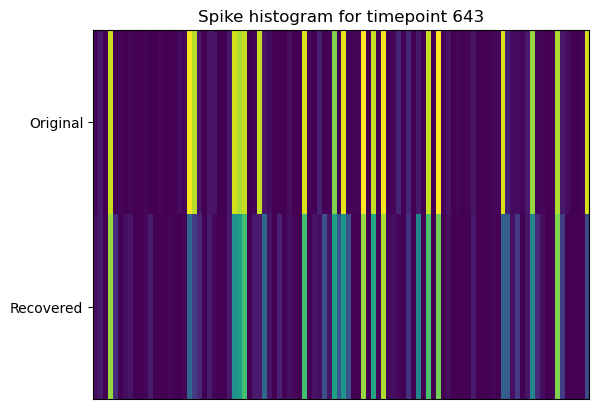

In [11]:
timepoint = 643 # for which timepoint should the spike histogram be plotted?

t_start_stimulus = time_points_dict["T"+ str(timepoint)+"_s"]
t_stop_stimulus = time_points_dict["T"+ str(timepoint)+"_e"]
t_start_recover = time_points_dict["T"+ str(timepoint+1)+"_s"]
t_stop_recover = time_points_dict["T"+ str(timepoint+off_time)+"_e"]
orig = spike_histogram(Mv, t_start=t_start_stimulus, t_stop=t_stop_stimulus).T[1]
recover = spike_histogram(Mv, t_start=t_start_recover+0.01*second, t_stop=t_stop_recover).T[1]

fig, ax = plt.subplots()
plt.imshow(np.row_stack((orig, recover)), aspect='auto', interpolation= "None")
plt.yticks(np.linspace(0, 1, 2),["Original", "Recovered"])
plt.title("Spike histogram for timepoint " + str(timepoint))
ax.set_xticks([])
plt.show()

In [12]:
# Function to save the output of the SRBM simulation
def save_output(unique = "", date = ""):
    '''Saves the output of the SRBM simulation in a pickle file.'''
    import pickle
    k_v, v_v = zip(*Mv.spike_trains().items())
    k_h, v_h = zip(*Mh.spike_trains().items())
    output = {"Mv": {"i":np.array(Mv.i), "t":np.array(Mv.t), 
                     "k": k_v, "v": v_v}, 
              "Mh": {"i":np.array(Mh.i), "t":np.array(Mh.t), 
                     "k": k_h, "v": v_h},
              "time_test_on":time_test_on,
              "time_test_off":time_test_off,
              "Ids":Ids,
              "timepoints":timepoints,
              "t_sim":t_sim,
              "time_points_dict":time_points_dict,
              "W":W,
              "b_v":b_v,
              "b_c":b_c,
              "b_h":b_h,
              "mB":mB,
              "Wvh":Wvh,
              "Wch":Wch,
              "mBv":mBv,
              "mBh":mBh,
              "sim_time":sim_time,
              "N_v":N_v,
              "N_c":N_c,
              "N_h":N_h,
              "beta_parameter":beta_parameter,
              "tau_rec":tau_rec,
              "dcmt":dcmt,
              "off_time":off_time,
              "n_seed_patterns": n_seed_patterns,
              "n_prototype_per_seed": n_prototype_per_seed,
              "n_variations_per_prototype": n_variations_per_prototype, 
              "after_split_n_per_prototype_train": len(train_test_data[0][0]), 
              "after_split_n_per_prototype_test": len(train_test_data[1][0])}                                 
    with open('output/'+unique+date+'.pkl', 'wb') as handle: # Python 3:
        pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Output saved as output/"+unique+date+".pkl")

In [13]:
# Save the output to open in the evaluation notebook
save_output(unique = "output_100_base_leak_x8", date = "")

Output saved as output/output_100_age_base_leak_x4.pkl
